# BinWaves example in Cantabria (Validation)

### BinWaves Notebooks Overview

This Jupyter Notebook is the first of three in the **BinWaves** modeling workflow, following Cagigal et al., 2024 :

1. `BinWaves_Propagation.ipynb`  
2. `BinWaves_Reconstruction.ipynb`  
3. `BinWaves_Validation.ipynb`

---

#### Before You Start

Make sure you have:

- Installed the latest version of `bluemath-tk`:  
  ```bash
  pip install bluemath-tk

Before continuing, ensure you have **created and activated a Python environment**.

*** Other Required Packages ***
- `wavespectra` 
- `cartophy`
 
---

<details>
<summary><strong>📁 BinWaves_Propagation.ipynb</strong></summary>

This notebook constructs the **library of pre-run cases** for all **monochromatic wave systems**.

##### Requirements:

- A **bathymetry** file placed in the `outputs/` folder, in the correct format.

If you don't have a specific bathymetry file for your study area, you can:

- **Download GEBCO bathymetry data** (~400 m resolution):  [https://download.gebco.net/](https://download.gebco.net/)


</details>

---

<details>
<summary><strong>📁 BinWaves_Reconstruction.ipynb</strong></summary>

This notebook reconstructs **wave conditions** using **offshore directional wave spectra**.

##### Requirements:

- Offshore wave spectrum data (e.g., **CAWCR** or **ERA5** datasets).
  - CAWCR spectra can be downloaded using a helper script (e.g., Javi's code?).

- **NOTE**: Optionally, apply **satellite corrections** to the hindcast spectrum before running BinWaves using the `CalVal` notebook, which handles the required format conversions.

</details>

---

<details open>
<summary><strong>📁 BinWaves_Validation.ipynb</strong></summary>

This notebook performs **validation** using **wave buoy data**, if available.

##### Requirements:

- Wave buoy data in a format compatible with BinWaves (if available).
- Some wave buoy data can be freely downloaded from:  
  🌊 [https://www.ndbc.noaa.gov/](https://www.ndbc.noaa.gov/)

- **NOTE:** You can use the `NDBC_buoy_data.ipynb` notebook to:
  - Download the buoy data.
  - Convert it into the appropriate format for BinWaves.

</details>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

# Define buoy locations dictionary with both UTM and WGS84 coordinates
# if not buoys available  just run plot_selected_bathy(bathy=bathy)
buoys = {
    "44088": (-74.8390, 36.6120),
    "44100": (-75.5930, 36.2580),
    "44086": (-75.4210, 36.0010),
    "44056": (-75.7140, 36.2000),
    "44095": (-75.3300, 35.7500),
    "41120": (-75.2850, 35.2580),
    "41025": (-75.4540, 35.0100),
    "41159": (-76.9440, 34.2110),
    "41110": (-77.7150, 34.1420),
    "41013": (-77.7640, 33.4410),
    "41108": (-78.0160, 33.7210),
}


def find_site_index(kp_coeffs, target_x, target_y, tolerance=1.0):
    """
    Find the site index in kp_coeffs that matches the target coordinates.

    Parameters:
    -----------
    kp_coeffs : xarray.Dataset
        The kp coefficients dataset
    target_x : float
        Target UTM x coordinate
    target_y : float
        Target UTM y coordinate
    tolerance : float
        Tolerance for coordinate matching (in meters)

    Returns:
    --------
    int
        The site index that matches the coordinates
    """
    # Get all site coordinates
    site_x = kp_coeffs.utm_x.values
    site_y = kp_coeffs.utm_y.values

    # Calculate distances to all sites
    distances = np.sqrt((site_x - target_x) ** 2 + (site_y - target_y) ** 2)

    # Find the site with minimum distance
    site_index = np.argmin(distances)

    # Check if the closest site is within tolerance
    if distances[site_index] > tolerance:
        print(f"Warning: Closest site is {distances[site_index]:.2f} meters away")

    return site_index


def load_buoy_data(buoy_id, year=None):
    """
    Load buoy data and return both the wave data and location coordinates.

    Parameters:
    -----------
    buoy_id : str
        The buoy ID (e.g., '44100')
    year : str, optional
        The year to filter data for (default: None)

    Returns:
    --------
    tuple
        (buoy_waves, buoy_location, kp_coeffs)
    """
    # Load buoy data
    buoy_waves = pd.read_pickle(
        f"inputs/buoy_{buoy_id}_bulk_parameters.pkl"
    ).sort_index()
    if year:
        buoy_waves = buoy_waves.loc[year]
    buoy_waves = buoy_waves.dropna(subset=["Hs_Buoy", "Tp_Buoy", "Dir_Buoy"])

    # Get buoy location (both UTM and WGS84)
    buoy_location = buoys[buoy_id]

    # Load kp coefficients
    kp_coeffs = xr.open_dataset("outputs/kp_coefficients.nc")

    # Find the correct site index
    site_index = find_site_index(kp_coeffs, buoy_location[0], buoy_location[1])

    # Select the correct site
    kp_coeffs = kp_coeffs.isel(site=[site_index])

    return buoy_waves, buoy_location, kp_coeffs


# Example usage:
buoy_id = "44088"  # Change this to use different buoys
buoy_waves, buoy_location, kp_coeffs = load_buoy_data(buoy_id, "2023")

# Print the coordinates for verification
print(f"Buoy {buoy_id} coordinates:")
print(f"WGS84: {buoy_location[0]}, {buoy_location[1]}")
print(f"\nSelected kp_coeffs site coordinates:")
print(f"{kp_coeffs.utm_x.values}, {kp_coeffs.utm_y.values}")

ModuleNotFoundError: No module named 'numpy._core.numeric'

In [ ]:
# import pandas as pd
# import xarray as xr

# # Load buoy data and kps

# buoy_waves = pd.read_pickle("outputs/buoy_44088_bulk_parameters.pkl").sort_index().loc["2022"]

# kp_coeffs = xr.open_dataset("outputs/kp_coefficients.nc").isel(site=[-11])
# kp_coeffs

In [7]:
kp_coeffs.utm_x.values, kp_coeffs.utm_y.values

(array([-74.839]), array([36.612]))

## Offshore Spectrum

> ⚠️ **NOTE:** If satellite correction was applied, ensure that 'satellite_correction=True'. The default value is False.

In [8]:
from utils.operations import transform_ERA5_spectrum

model_parameters = pd.read_csv("NC_SC/swan_cases.csv").to_dict(orient="list")

# Load interest spectra
offshore_spectra, offshore_spectra_case = transform_ERA5_spectrum(
    era5_spectrum=xr.open_dataset("outputs/satellite_corrected_44088_spectrum_cal.nc"),
    subset_parameters=model_parameters,
    available_case_num=kp_coeffs.case_num.values,
    satellite_correction=True,
)
offshore_spectra_case

<xarray.DataArray 'efth' (case_num: 696, time: 405963)> Size: 2GB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.71341895e-19],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(696, 405963))
Coordinates:
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * time      (time) datetime64[ns] 3MB 1979-01-01 ... 2025-04-01
    station   int32 4B 133

In [9]:
import numpy as np
from bluemath_tk.waves.binwaves import reconstruc_spectra

# First, ensure unique times in offshore_spectra_case
_, unique_idx_offshore = np.unique(offshore_spectra_case.time, return_index=True)
offshore_spectra_case = offshore_spectra_case.isel(time=unique_idx_offshore)

# Then, ensure unique times in buoy_waves
buoy_waves = buoy_waves[~buoy_waves.index.duplicated(keep="first")]


reconstructed_onshore_spectra = reconstruc_spectra(
    offshore_spectra=offshore_spectra_case.sel(time=buoy_waves.index, method="nearest"),
    kp_coeffs=kp_coeffs,
    num_workers=8,
)
reconstructed_onshore_spectra

/home/grupos/geocean/montanoj/miniforge3/envs/bluemath-stable/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40953 instead
  warnings.warn(
/home/grupos/geocean/montanoj/miniforge3/envs/bluemath-stable/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 92.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 104MB
Dimensions:  (site: 1, freq: 31, dir: 24, time: 17437)
Coordinates:
  * site     (site) int64 8B 526
  * freq     (freq) float64 248B 0.03 0.0329 0.0362 0.0397 ... 0.4145 0.4552 0.5
  * dir      (dir) float64 192B 2.5 17.5 32.5 47.5 ... 302.5 317.5 332.5 347.5
    lat      float64 8B 0.0
    lon      float64 8B 0.0
    utm_x    (site) float64 8B -74.84
    utm_y    (site) float64 8B 36.61
  * time     (time) datetime64[ns] 139kB 2023-01-01 ... 2023-12-31T23:00:00.0...
    station  int32 4B 133
Data variables:
    kps      (time, site, freq, dir) float64 104MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

/home/grupos/geocean/montanoj/miniforge3/envs/bluemath-stable/lib/python3.13/site-packages/xarray/plot/dataarray_plot.py:512: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/home/grupos/geocean/montanoj/miniforge3/envs/bluemath-stable/lib/python3.13/site-packages/xarray/plot/dataarray_plot.py:512: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


ValueError: array must not contain infs or NaNs

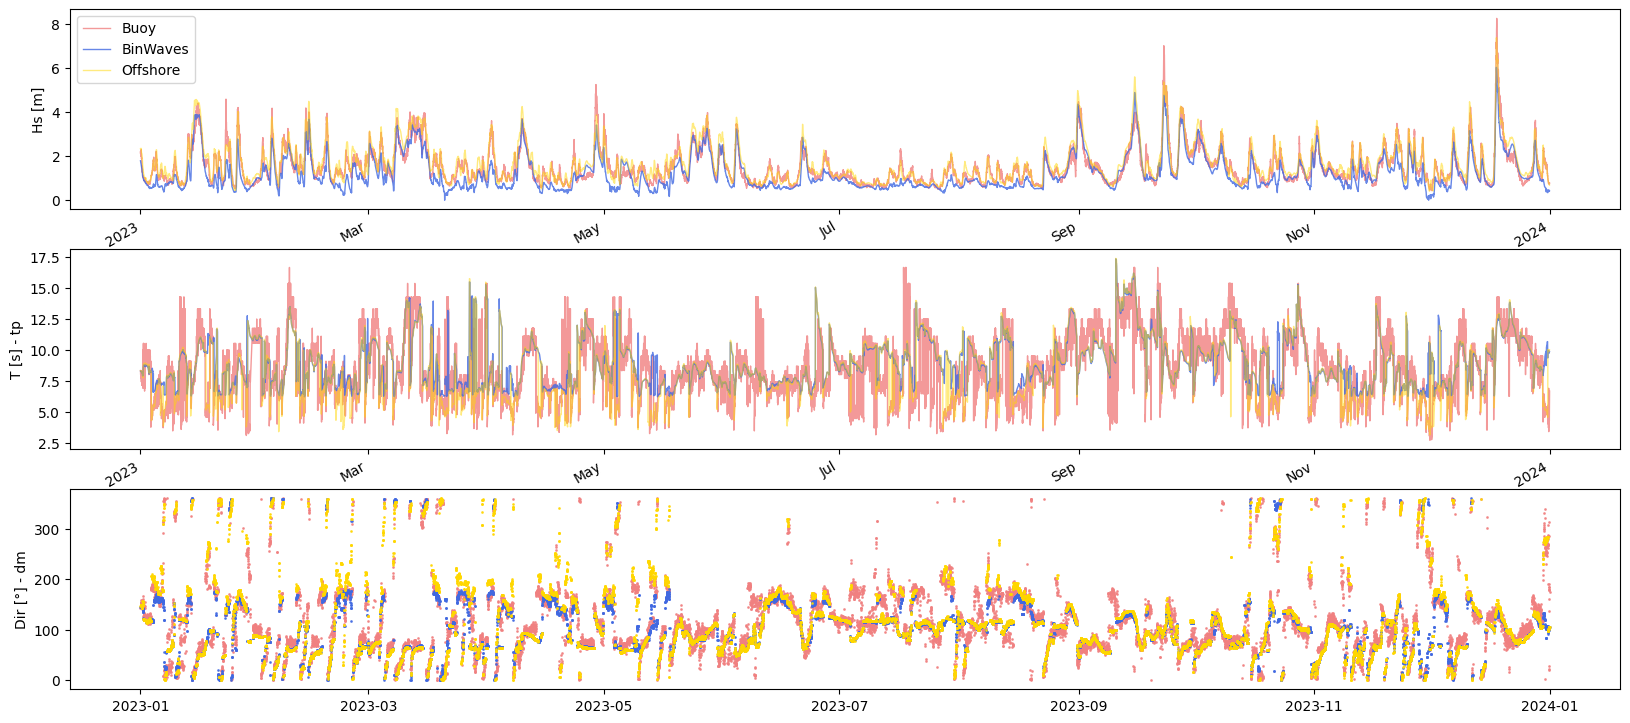

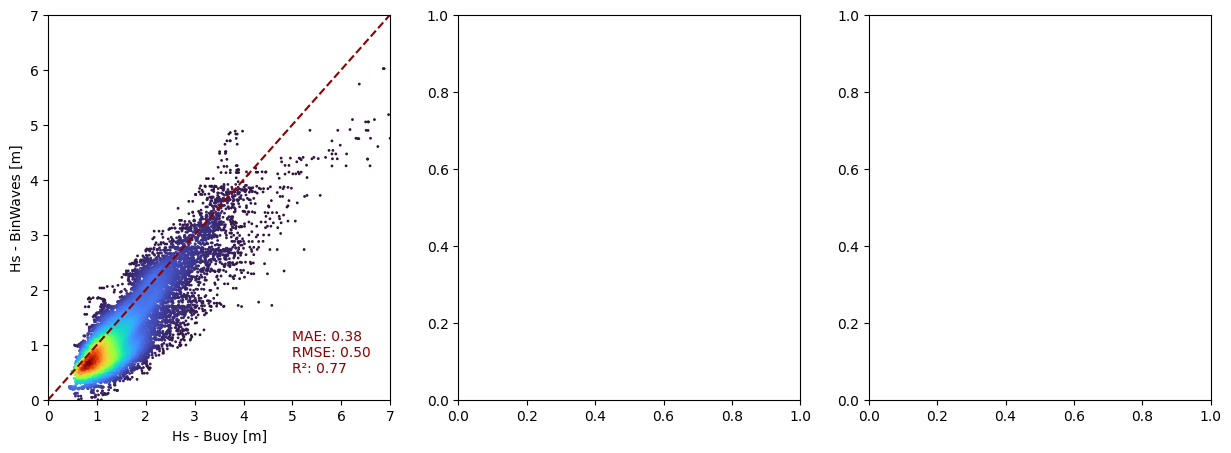

In [10]:
# TODO: Check why for some years it fails due to NaNs in the reconstructed spectra
from utils.plotting import plot_wave_series

# First ensure all datasets have unique time values
_, unique_idx_recon = np.unique(reconstructed_onshore_spectra.time, return_index=True)
reconstructed_onshore_spectra = reconstructed_onshore_spectra.isel(
    time=unique_idx_recon
)

_, unique_idx_offshore = np.unique(offshore_spectra.time, return_index=True)
offshore_spectra = offshore_spectra.isel(time=unique_idx_offshore)

# Make sure buoy_waves has unique indices (if not already done)
buoy_waves = buoy_waves[~buoy_waves.index.duplicated(keep="first")]

# Now plot with the deduplicated datasets
plot_wave_series(
    buoy_data=buoy_waves,
    binwaves_data=reconstructed_onshore_spectra.sel(
        time=buoy_waves.index, method="nearest"
    )
    .rename({"kps": "efth"})
    .squeeze()
    .spec,
    offshore_data=offshore_spectra.sel(time=buoy_waves.index, method="nearest").spec,
    times=buoy_waves.index.values,
)